In [1]:
import mne
import os
import glob

# Load ALL resting state files from raw directory
raw_dir = os.path.join('..', '..', 'raw')

# Find all files with "RestingState" in the name
resting_files = glob.glob(os.path.join(raw_dir, "*RestingState*.set"))

print(f"Found {len(resting_files)} resting state files:")
for f in resting_files:
    print(f"  - {os.path.basename(f)}")

# Load all files
raw_list = []
for file_path in resting_files:
    print(f"\nLoading {os.path.basename(file_path)}...")
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    raw_list.append(raw)
    print(f"  ✓ Channels: {len(raw.ch_names)}, Duration: {raw.times[-1]:.1f}s")

print(f"\n✓ Loaded {len(raw_list)} resting state recordings")

Found 90 resting state files:
  - sub-NDARAA396TWZ_task-RestingState_eeg (1).set
  - sub-NDARAA396TWZ_task-RestingState_eeg.set
  - sub-NDARAA773LUW_task-RestingState_eeg.set
  - sub-NDARAB674LNB_task-RestingState_eeg.set
  - sub-NDARAC688ZM5_task-RestingState_eeg.set
  - sub-NDARAC923GPW_task-RestingState_eeg.set
  - sub-NDARAD269FZD_task-RestingState_eeg.set
  - sub-NDARAE540FCG_task-RestingState_eeg.set
  - sub-NDARAG644KE3_task-RestingState_eeg.set
  - sub-NDARAH129BMC_task-RestingState_eeg.set
  - sub-NDARAL606CW5_task-RestingState_eeg.set
  - sub-NDARAN229MTX_task-RestingState_eeg.set
  - sub-NDARAP120HTA_task-RestingState_eeg.set
  - sub-NDARAR335FZH_task-RestingState_eeg.set
  - sub-NDARAR358RHK_task-RestingState_eeg.set
  - sub-NDARAR935TGZ_task-RestingState_eeg.set
  - sub-NDARAR991JAA_task-RestingState_eeg.set
  - sub-NDARAR998KMM_task-RestingState_eeg.set
  - sub-NDARAT000LDV_task-RestingState_eeg.set
  - sub-NDARAT193FC0_task-RestingState_eeg.set
  - sub-NDARAU044FP6_task-

C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 357.7s

Loading sub-NDARAB674LNB_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 350.0s

Loading sub-NDARAC688ZM5_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 320.5s

Loading sub-NDARAC923GPW_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 317.1s

Loading sub-NDARAD269FZD_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 353.9s

Loading sub-NDARAE540FCG_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 319.8s

Loading sub-NDARAG644KE3_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 501.8s

Loading sub-NDARAH129BMC_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 916.9s

Loading sub-NDARAL606CW5_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 326.2s

Loading sub-NDARAN229MTX_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 318.0s

Loading sub-NDARAP120HTA_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 386.8s

Loading sub-NDARAR335FZH_task-RestingState_eeg.set...
  ✓ Channels: 129, Duration: 323.9s

Loading sub-NDARAR358RHK_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 370.4s

Loading sub-NDARAR935TGZ_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 410.7s

Loading sub-NDARAR991JAA_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 327.5s

Loading sub-NDARAR998KMM_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 494.3s

Loading sub-NDARAT000LDV_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 384.1s

Loading sub-NDARAT193FC0_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 364.0s

Loading sub-NDARAU044FP6_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 349.4s

Loading sub-NDARAV082JHA_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 363.3s

Loading sub-NDARAV474ADJ_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 365.7s

Loading sub-NDARAV925BP3_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 439.5s

Loading sub-NDARAY596ZWD_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 439.4s

Loading sub-NDARAZ069DBL_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 352.2s

Loading sub-NDARBA404HR9_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 322.6s

Loading sub-NDARBC202FT0_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 366.0s

Loading sub-NDARBC773HN6_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 357.3s

Loading sub-NDARBC865CXQ_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 376.0s

Loading sub-NDARBD347AG0_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 363.6s

Loading sub-NDARBE081CU3_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 352.3s

Loading sub-NDARBF575JUL_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 317.7s

Loading sub-NDARBF911MLX_task-RestingState_eeg.set...
  ✓ Channels: 129, Duration: 1113.3s

Loading sub-NDARBG073ZY4_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 451.4s

Loading sub-NDARBH502NZ9_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 344.4s

Loading sub-NDARBH701KA1_task-RestingState_eeg.set...
  ✓ Channels: 129, Duration: 198.3s

Loading sub-NDARBK739HXR_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 349.0s

Loading sub-NDARBL990KHP_task-RestingState_eeg.set...
  ✓ Channels: 129, Duration: 361.2s

Loading sub-NDARBM037ZM7_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 354.3s

Loading sub-NDARBM348NAN_task-RestingState_eeg.set...
  ✓ Channels: 129, Duration: 357.8s

Loading sub-NDARBN695TM7_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 356.3s

Loading sub-NDARBP516PXX_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 359.5s

Loading sub-NDARBR039KM0_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 318.6s

Loading sub-NDARBT094VX0_task-RestingState_eeg.set...
  ✓ Channels: 129, Duration: 254.5s

Loading sub-NDARBT579AW1_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 317.7s

Loading sub-NDARBT980MW2_task-RestingState_eeg.set...
  ✓ Channels: 129, Duration: 398.7s

Loading sub-NDARBU451LDR_task-RestingState_eeg.set...
  ✓ Channels: 129, Duration: 330.3s

Loading sub-NDARBV198EKU_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 336.5s

Loading sub-NDARBW660FLT_task-RestingState_eeg.set...
  ✓ Channels: 129, Duration: 798.9s

Loading sub-NDARBX479JVN_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 585.0s

Loading sub-NDARBY976XYY_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 349.6s

Loading sub-NDARCA851LUG_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 354.5s

Loading sub-NDARCB620LXQ_task-RestingState_eeg.set...
  ✓ Channels: 129, Duration: 366.0s

Loading sub-NDARCB869VM8_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 528.9s

Loading sub-NDARCC909PYL_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 346.0s

Loading sub-NDARCD075CMG_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 345.9s

Loading sub-NDARCE788KXW_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 319.2s

Loading sub-NDARCE803VF5_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 344.0s

Loading sub-NDARCF658ZMQ_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 514.7s

Loading sub-NDARCG343UF4_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 916.6s

Loading sub-NDARCJ014BCH_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 357.7s

Loading sub-NDARCJ348YVB_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 321.1s

Loading sub-NDARCJ667UPL_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 403.5s

Loading sub-NDARCK816LRX_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 362.1s

Loading sub-NDARCL586HXH_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 316.3s

Loading sub-NDARCM027TAV_task-RestingState_eeg.set...
  ✓ Channels: 129, Duration: 363.4s

Loading sub-NDARCM080BVQ_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 352.3s

Loading sub-NDARCM082AZD_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 318.8s

Loading sub-NDARCM639ZNA_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 357.1s

Loading sub-NDARCM677TC1_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 368.6s

Loading sub-NDARCN497LVY_task-RestingState_eeg.set...
  ✓ Channels: 129, Duration: 405.9s

Loading sub-NDARCT119UKU_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 341.0s

Loading sub-NDARCU057BFP_task-RestingState_eeg.set...
  ✓ Channels: 129, Duration: 365.2s

Loading sub-NDARCW855EMQ_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 326.5s

Loading sub-NDARCY682FLJ_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 375.3s

Loading sub-NDARDC553RE2_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 572.3s

Loading sub-NDARDD820LG7_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 354.6s

Loading sub-NDARDE355JYM_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 539.7s

Loading sub-NDARDF166XVA_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 355.9s

Loading sub-NDARDF877LW4_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 439.2s

Loading sub-NDARDG528KWJ_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 355.0s

Loading sub-NDARDG644LJX_task-RestingState_eeg.set...
  ✓ Channels: 129, Duration: 362.3s

Loading sub-NDARDK635CD2_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 362.9s

Loading sub-NDARDM027XFE_task-RestingState_eeg.set...
  ✓ Channels: 129, Duration: 658.4s

Loading sub-NDARDN446FJG_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 575.3s

Loading sub-NDARDP740CLE_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 392.5s

Loading sub-NDARDP815CNW_task-RestingState_eeg.set...
  ✓ Channels: 129, Duration: 643.6s

Loading sub-NDARDR898FMV_task-RestingState_eeg.set...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


  ✓ Channels: 129, Duration: 363.8s

Loading sub-NDARDV122YZN_task-RestingState_eeg.set...
  ✓ Channels: 129, Duration: 342.5s

✓ Loaded 90 resting state recordings


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\1019575733.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


In [3]:
# low-pass filter at 45 Hz
raw = [r.filter(l_freq=None, h_freq=45, fir_design='firwin') for r in raw_list]

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 147 samples (0.294 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 147 samples (0.294 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter par

In [ ]:
# from asrpy import ASR
# import numpy as np


# for i, r in enumerate(raw):
#     asr = ASR(sfreq=r.info['sfreq'], cutoff=20)
#     asr.fit(r) 

#     raw[i] = asr.transform(r)
# requires alot of computing and memory power, so commented out for now


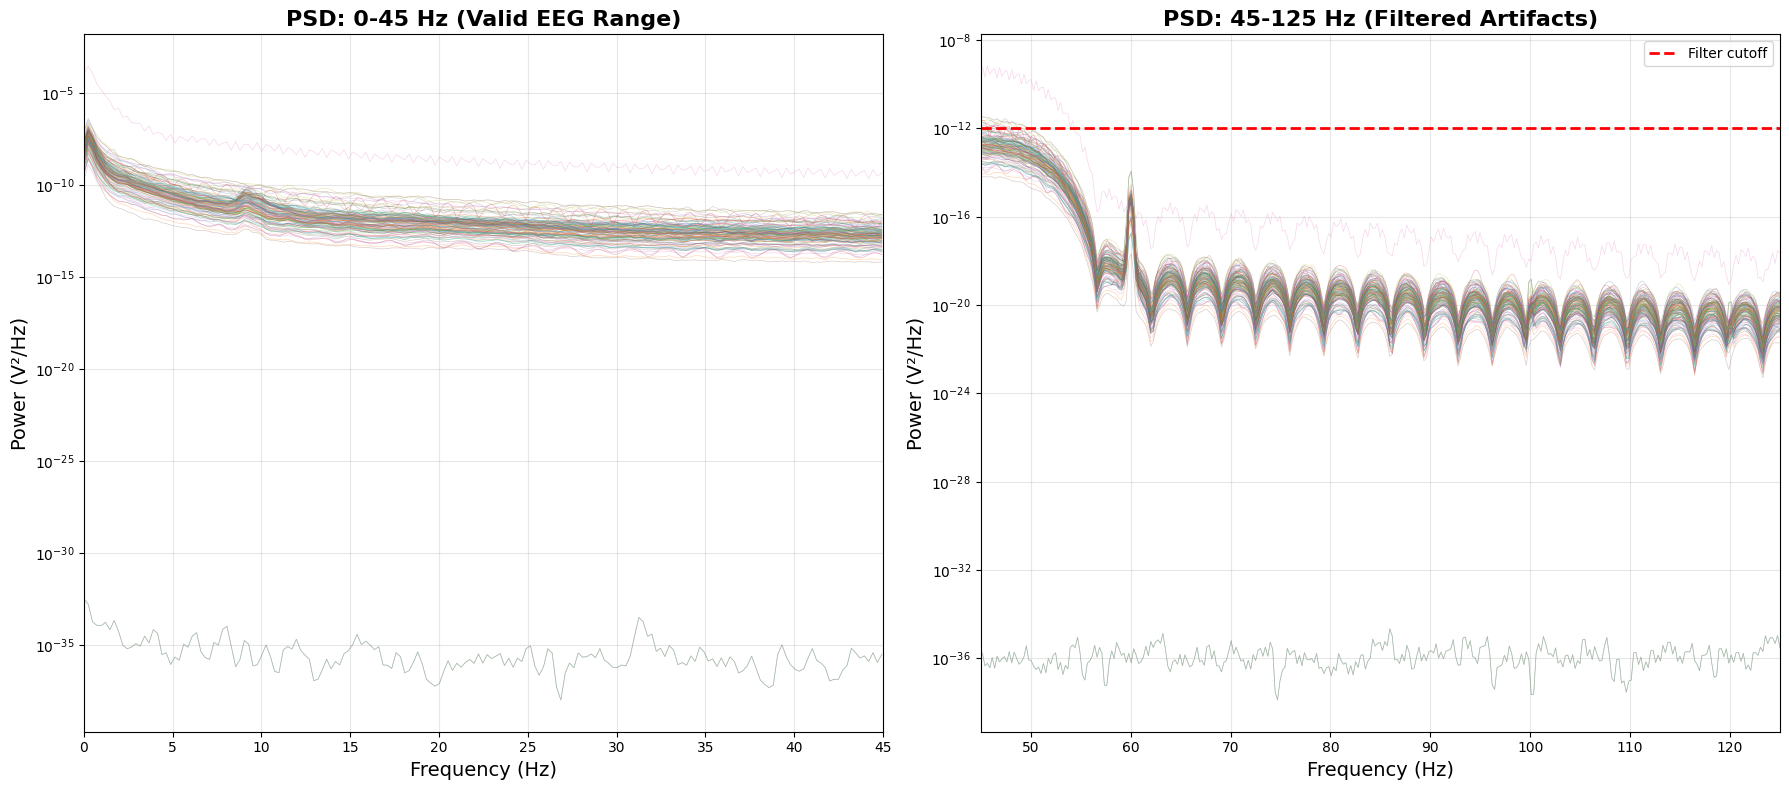

In [7]:
# Check PSD with correct expectations (1-45 Hz cutoff)
from scipy import signal as sp_signal
import matplotlib.pyplot as plt
import numpy as np

data = raw[0].get_data()

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 0-45 Hz (your valid range)
for i in range(len(raw[0].ch_names)):
    freqs, psd = sp_signal.welch(data[i], fs=raw[0].info['sfreq'], nperseg=2048)
    mask = (freqs >= 0) & (freqs <= 45) & (psd > 0)
    axes[0].semilogy(freqs[mask], psd[mask], alpha=0.3, linewidth=0.5)

axes[0].set_xlabel('Frequency (Hz)', fontsize=14)
axes[0].set_ylabel('Power (V²/Hz)', fontsize=14)
axes[0].set_title('PSD: 0-45 Hz (Valid EEG Range)', fontsize=16, fontweight='bold')
axes[0].set_xlim(0, 45)
axes[0].grid(True, alpha=0.3)

# Plot 45-125 Hz (should be near zero due to filter)
for i in range(len(raw[0].ch_names)):
    freqs, psd = sp_signal.welch(data[i], fs=raw[0].info['sfreq'], nperseg=2048)
    mask = (freqs >= 45) & (freqs <= 125) & (psd > 0)
    axes[1].semilogy(freqs[mask], psd[mask], alpha=0.3, linewidth=0.5)

axes[1].set_xlabel('Frequency (Hz)', fontsize=14)
axes[1].set_ylabel('Power (V²/Hz)', fontsize=14)
axes[1].set_title('PSD: 45-125 Hz (Filtered Artifacts)', fontsize=16, fontweight='bold')
axes[1].set_xlim(45, 125)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=1e-12, color='red', linestyle='--', linewidth=2, label='Filter cutoff')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join('..', '..', 'figures', 'psd_diagnostic.png'), dpi=150)
plt.show()

In [8]:
# Save cleaned data in different formats

processed_dir = os.path.join('..', '..', 'processed')
os.makedirs(processed_dir, exist_ok=True)

# save as fif
for i, r in enumerate(raw):
    output_path_fif = os.path.join(processed_dir, f'resting_state_cleaned_{i}.fif')
    r.save(output_path_fif, overwrite=True)
    print(f"✓ Saved as FIF: {output_path_fif}")

# save metadata as numpy
for i, r in enumerate(raw):

    metadata = {
        'ch_names': r.ch_names,
        'sfreq': r.info['sfreq'],
        'n_channels': len(r.ch_names),
        'n_times': r.n_times
    }
    metadata_path = os.path.join(processed_dir, f'resting_state_metadata{i}.npy')
    np.save(metadata_path, metadata)
    print(f"✓ Saved metadata: {metadata_path}")

print("\n" + "="*60)
print("SAVED CLEANED DATA")
print("="*60)
print(f"Channels: {len(raw[0].ch_names)}")
print(f"Sampling rate: {raw[0].info['sfreq']} Hz")
print(f"Duration: {raw[0].times[-1]:.1f} seconds")
print(f"Data shape: {raw[0].get_data().shape}")
print("="*60)

Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_0.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_0.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_0.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_0.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_1.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_0.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_1.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_1.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_1.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_2.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_1.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_2.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_2.fif
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_2.fif


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_2.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_3.fif
Overwriting existing file.
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_2.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_3.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_3.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_3.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_4.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_3.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_3.fif
Overwriting existing file.
Writing c:\Users\JIN

C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)
C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_4.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_4.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_5.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_4.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_5.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_5.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_5.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_5.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_5.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)
C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_6.fif
Overwriting existing file.
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_6.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_6.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_7.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_6.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_6.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_7.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_7.fif
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\

C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_7.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_8.fif
Overwriting existing file.
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_7.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_8.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_8.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_8.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_8.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_9.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_8.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_9.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_9.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_9.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_9.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_10.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_9.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_10.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_10.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_10.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_11.fif
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_10.fif
[done]
✓ Saved as FIF:

C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_10.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)
C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_11.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_11.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_11.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_12.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_11.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_11.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_12.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_12.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_12.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_12.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_13.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_12.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_13.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_13.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_13.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_14.fif
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_13.fif
[done]
✓ Saved as F

C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_13.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)
C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_14.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_14.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_14.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_15.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_14.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_14.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_15.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_15.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_15.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_15.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_16.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_15.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_16.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_16.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_16.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_17.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned

C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_16.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)
C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_17.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_17.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_17.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_17.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_18.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_18.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_18.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_18.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_18.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_19.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_18.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_19.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_19.fif
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_19.fif


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_19.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_19.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_20.fif
Overwriting existing file.
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_19.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_20.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_20.fif
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_20.fif


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_20.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_20.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_21.fif
Overwriting existing file.
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_20.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_21.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_21.fif
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_21.fif


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_21.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_21.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_22.fif
Overwriting existing file.
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_21.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_22.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_22.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_22.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_22.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_23.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_22.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_23.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_23.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_23.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_23.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_24.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_23.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_24.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_24.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_24.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_24.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_25.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_24.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_25.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_25.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_25.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_25.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_26.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_25.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_26.fif
Overwriting existing file.
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_26.fif
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_26.fif


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_26.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_26.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_27.fif
Overwriting existing file.
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_26.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_27.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_27.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_27.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_27.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_28.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_27.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_28.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_28.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_28.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_28.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_29.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_28.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_29.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_29.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_29.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_29.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_30.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_29.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_30.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_30.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_30.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_30.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_31.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_30.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_31.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_31.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_31.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_31.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_32.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_31.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_32.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_32.fif
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_32.fif


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_32.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_32.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_33.fif
Overwriting existing file.
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_32.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_33.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_33.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_33.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_33.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_34.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_33.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_34.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_34.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_34.fif
[done]
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_34.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_35.fif
Overwriting existing file.
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_34.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_35.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_35.fif
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_35.fif


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_35.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_35.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_36.fif
Overwriting existing file.
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_35.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_36.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_36.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_36.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_37.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_36.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_36.fif
Overwriting existing file.
Writing c:\

C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_36.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)
C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_37.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_37.fif
[done]
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_37.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_38.fif
Overwriting existing file.
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_37.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_38.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_38.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_38.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_38.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_39.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_38.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_39.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_39.fif
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_39.fif


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_39.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_39.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_40.fif
Overwriting existing file.
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_39.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_40.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_40.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_40.fif
[done]
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_40.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_41.fif
Overwriting existing file.
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_40.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_41.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_41.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_41.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_41.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_42.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_41.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_42.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_42.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_42.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_42.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_43.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_42.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_43.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_43.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_43.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_43.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_43.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_43.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)
C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_44.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_44.fif
Overwriting existing file.
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_44.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_44.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_45.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_44.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_44.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_45.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_45.fif
[done]
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\j

C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_45.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)
C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_46.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_46.fif
Overwriting existing file.
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_46.fif
[done]
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_46.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_46.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_47.fif
Overwriting existing file.
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_46.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_47.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_47.fif
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-n

C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_47.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_47.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_48.fif
Overwriting existing file.
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_47.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_48.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_48.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_48.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_48.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_49.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_48.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_49.fif
Overwriting existing file.
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_49.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_49.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_49.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_50.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_49.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_50.fif
Overwriting existing file.
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_50.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_50.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_50.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_51.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_50.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_51.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_51.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_51.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_51.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_51.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_52.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_52.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_52.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_52.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_52.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_53.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_52.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_53.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_53.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_53.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_53.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_53.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_54.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_54.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_54.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_54.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_54.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_55.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_54.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_55.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_55.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_55.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_55.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_56.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_55.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_56.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_56.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_56.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_56.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_56.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_57.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_57.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_57.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_57.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_57.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_58.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_57.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_58.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_58.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_58.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_58.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_59.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_58.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_59.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_59.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_59.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_59.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_60.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_59.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_60.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_60.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_60.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_60.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_61.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_60.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_61.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_61.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_61.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_61.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_62.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_61.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_62.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_62.fif
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_62.fif


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_62.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_62.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_63.fif
Overwriting existing file.
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_62.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_63.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_63.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_63.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_63.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_64.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_63.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_64.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_64.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_64.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_64.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_65.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_64.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_65.fif
Overwriting existing file.
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_65.fif
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_65.fif


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_65.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_65.fif
Overwriting existing file.
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_65.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_66.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_66.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_66.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_66.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_66.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_67.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_66.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_67.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_67.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_67.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_67.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_68.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_67.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_68.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_68.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_68.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_68.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_69.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_68.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_69.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_69.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_69.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_69.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_70.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_69.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_70.fif
Overwriting existing file.
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_70.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_70.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_70.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_71.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_70.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_71.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_71.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_71.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_71.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_72.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_71.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_72.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_72.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_72.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_72.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_73.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_72.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_73.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_73.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_73.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_73.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_74.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_73.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_74.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_74.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_74.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_74.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_75.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_74.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_75.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_75.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_75.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_75.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_76.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_75.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_76.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_76.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_76.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_76.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_77.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_76.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_77.fif
Overwriting existing file.
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_77.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_77.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_77.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_78.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_77.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_78.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_78.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_78.fif
[done]
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_78.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_79.fif
Overwriting existing file.
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_78.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_79.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_79.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_79.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_79.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_80.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_79.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_80.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_80.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_80.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_80.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_81.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_80.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_81.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_81.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_81.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_81.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_82.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_81.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_82.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_82.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_82.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_82.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_83.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_82.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_83.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_83.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_83.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_83.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_84.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_83.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_84.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_84.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_84.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_84.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_85.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_84.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_85.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_85.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_85.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_85.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_86.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_85.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_86.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_86.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_86.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_86.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_87.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_86.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_87.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_87.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_87.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_87.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_88.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_87.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_88.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_88.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_88.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_88.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_89.fif
Overwriting existing file.
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_88.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_89.fif
Overwriting existing file.
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_89.fif
[done]
Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_89.fif
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned_89.fif
✓ Saved metadata: ..\..\processed\resting_state_metadata0.npy
✓ Saved metadata: ..\..\processed\resting_state_metadata1.npy
✓ Saved metadata: ..\.

C:\Users\JINQI\AppData\Local\Temp\ipykernel_34560\3039389205.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned_89.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r.save(output_path_fif, overwrite=True)


✓ Saved metadata: ..\..\processed\resting_state_metadata24.npy
✓ Saved metadata: ..\..\processed\resting_state_metadata25.npy
✓ Saved metadata: ..\..\processed\resting_state_metadata26.npy
✓ Saved metadata: ..\..\processed\resting_state_metadata27.npy
✓ Saved metadata: ..\..\processed\resting_state_metadata28.npy
✓ Saved metadata: ..\..\processed\resting_state_metadata29.npy
✓ Saved metadata: ..\..\processed\resting_state_metadata30.npy
✓ Saved metadata: ..\..\processed\resting_state_metadata31.npy
✓ Saved metadata: ..\..\processed\resting_state_metadata32.npy
✓ Saved metadata: ..\..\processed\resting_state_metadata33.npy
✓ Saved metadata: ..\..\processed\resting_state_metadata34.npy
✓ Saved metadata: ..\..\processed\resting_state_metadata35.npy
✓ Saved metadata: ..\..\processed\resting_state_metadata36.npy
✓ Saved metadata: ..\..\processed\resting_state_metadata37.npy
✓ Saved metadata: ..\..\processed\resting_state_metadata38.npy
✓ Saved metadata: ..\..\processed\resting_state_metadat